# Mixture of Gaussians with gpclust

### James Hensman, November 2014
### Daniel Marthaler September 2016

This is a very simple demo to show how to use gpclust to build a mixture of Gaussians. We'll grab some toy data, fit the model and do some very simple analyis of the posterior. We'll also have a look at the truncated Dirichlet process approximation, and how to run a merge-split method to find the optimal number of clusters. Finally we'll examine the effect of changing the priors over the cluster components. 

In [1]:
import numpy as np
from matplotlib import pyplot as plt

#configure plotting
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib
matplotlib.rcParams['figure.figsize'] =  (8,5)
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['font.family'] = 'serif'

np.random.seed(0)
import sys

In [2]:
X = np.load('twoD_clustering_example.npz')['X']
print(X.shape)

(506, 2)


We have a two-dimensional dataset, with 506 data.

Building the model is as simple as importing the gpclust library and calling the class constructor with our data. The argument num_clusters specifies how many clusters to use.

In [3]:
import gpclust
m = gpclust.MOG(X, num_clusters=10)

For two-dimensional data, there's a handy built-in plot function:

In [4]:
from plotter import MOGplot

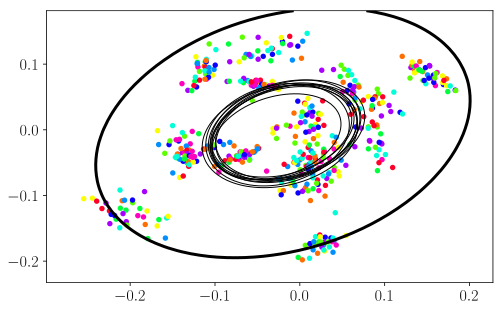

In [5]:
MOGplot(m,X)

Here, the data are colored according to the (most probably) assigned cluster, and the heavy line(s) show the contours of the models probability density. Thin lines show the countours of the probablity density of each component.

We can see that the model has not been fitted yet! The variational approximation to the posterior is initialized randomly, i.e. all data are randomly assigned across the clusters. To fit the approximation, call the optimize routine, and plot again. 

In [6]:
m.optimize(maxiter=20)

iteration 1 bound=840.246019227 grad=308.768968655, beta=0
iteration 2 bound=840.904561567 grad=0.5613430072, beta=0.000250417012151
iteration 3 bound=844.314288715 grad=1.08982235996, beta=1.7277949045
iteration 4 bound=862.673533916 grad=4.42994816203, beta=2.10359499264
iteration 5 bound=905.374714632 grad=20.0128078023, beta=1.69034353613
iteration 6 bound=942.909387451 grad=32.1425539081, beta=0.883231079861
iteration 7 bound=951.980447297 grad=16.233428575, beta=2.73792297837
iteration 8 bound=982.454196421 grad=36.3173938328, beta=0.0
iteration 9 bound=1002.59544054 grad=23.2327281544, beta=0.0
iteration 10 bound=1032.68833392 grad=25.7426422524, beta=0.771600459367
iteration 11 bound=1048.80397272 grad=30.1710003089, beta=1.25240914987
iteration 13 bound=1089.39530576 grad=77.1778271455, beta=2.26003676588
iteration 14 bound=1111.1106754 grad=26.0908266771, beta=0.0
iteration 15 bound=1141.240393 grad=26.8089138708, beta=1.21756561542
iteration 16 bound=1151.8330786 grad=50.028

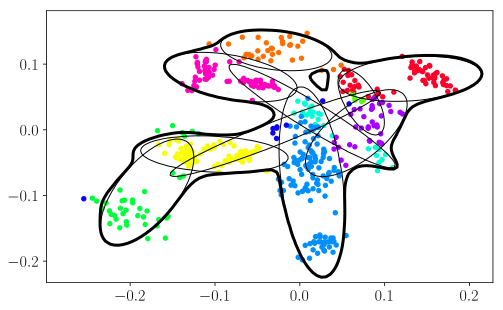

In [7]:
MOGplot(m,X)

# Dirichlet process priors and the merge-split method

Instead of using a fixed number of clusters, we can place a Dirichlet process prior over the component weights: effectively a prior of an infintie number of clusters. The variational approximation is _truncated_ so we still only model a finite number of clusters, but now we can optimize for the number of components.

To help explore the search space, GPclust has a `try_split` function. This re-initializes the posterior with a given cluster 'split' into two clusters. Attempted splits are only accepted if the bound on the marginal likelihood increases.  A wrapper around the `try_split()`, method, `systematic_splits()` repeatedly attempts splits. 

Let's build a MOG with a DP prior, truncated at four components and optimize the hyperparameters:

In [4]:
m = gpclust.MOG(X, num_clusters=4, prior_Z='DP', alpha=10.)
m.optimize()

iteration 1 bound=912.912321581 grad=199.868625298, beta=0
iteration 2 bound=913.238078297 grad=0.287673332159, beta=0.0
iteration 3 bound=914.779839745 grad=0.504855072448, beta=1.70191999932
iteration 4 bound=923.26823716 grad=1.87485671861, beta=2.03592125296
iteration 5 bound=951.316365131 grad=8.90466610736, beta=1.87004778396
iteration 6 bound=983.689010217 grad=21.7471609417, beta=1.10683671627
iteration 7 bound=999.038873905 grad=15.077567053, beta=0.561516300379
iteration 8 bound=1003.81453608 grad=5.70686326211, beta=0.0
iteration 9 bound=1007.72559284 grad=4.2379455319, beta=0.0
iteration 10 bound=1016.47064818 grad=4.26083198396, beta=1.39947161558
iteration 11 bound=1034.03554965 grad=6.65704783245, beta=1.58678448493
iteration 12 bound=1048.6820376 grad=12.6379148429, beta=0.972606304339
iteration 13 bound=1059.42555536 grad=9.85704860812, beta=0.670659943573
iteration 14 bound=1072.73238926 grad=11.0914704199, beta=1.02546049079
iteration 15 bound=1083.02268189 grad=9.43

In [5]:
MOGplot(m,X)

NameError: name 'MOGplot' is not defined

With only four components, the fit is quite poor. To attempt to split the $i^\textrm{th}$ component, call `try_split(i)`. The method returns `True` if the split was sucessful, and displays the current status after each split attempt. 

In [10]:
m.try_split(1)


attempting to split cluster  1
iteration 1 bound=1152.41049525 grad=44.4316268031, beta=0
iteration 2 bound=1167.66834481 grad=32.557026807, beta=0.576409074761
iteration 3 bound=1176.62141646 grad=12.1058701537, beta=0.0970946698547
iteration 4 bound=1179.83817221 grad=5.11419948303, beta=0.0
iteration 5 bound=1180.8305988 grad=1.70445960484, beta=0.0314447847986
iteration 6 bound=1181.05843484 grad=0.285272429063, beta=0.212453496211
iteration 7 bound=1181.12212501 grad=0.0616992978642, beta=0.127678969729
iteration 8 bound=1181.17552402 grad=0.035918943621, beta=0.552342233649
iteration 9 bound=1181.20810644 grad=0.0173312589737, beta=0.573860603823
iteration 10 bound=1181.22255112 grad=0.00715033132546, beta=0.46405602095
iteration 11 bound=1181.22923487 grad=0.0040191081723, beta=0.318801276653
iteration 12 bound=1181.23492221 grad=0.00317256839581, beta=0.492285594748
iteration 13 bound=1181.24043534 grad=0.00262620629714, beta=0.608215357735
iteration 14 bound=1181.24604093 gra

True

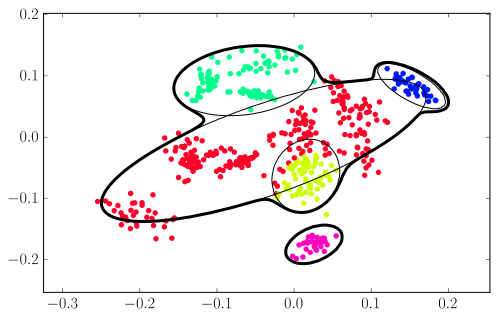

In [11]:
MOGplot(m,X)

We can see that in attempting to split the first cluster, the bound on the marginal likelihood has increased and the move was accepted. To save having to repeatedly call the `try_split` method, there's a helpful `systematic_splits()` function, which iterates through each cluster and attempts to split it until the marginal-likelihood bound fails to increase. Here we'll turn the output off (`verbose=False`), as it can get a bit long.

In [12]:
m.systematic_splits(verbose=False)

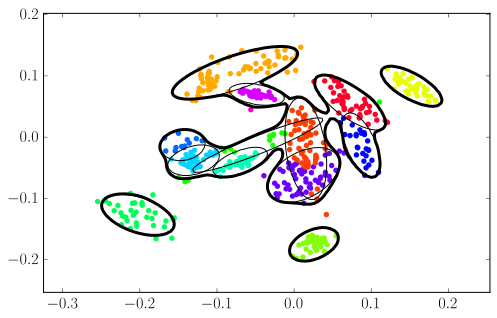

In [13]:
MOGplot(m,X)

## Getting at the parameters of the posterior. 
There are perhaps three main tasks that we'd like to do with the fitted model:
* See which data are assigned to the same cluster
* Examine the means (and variances) of the cluster components
* Predict the probability density at a new point

The posterior over data assignments is stored in a matrix called `phi`. This matrix is NxK (number of data by number of clusters), and each element $\phi_{nk}$ represents the probability that the $n^\textrm{th}$ datum is assigned to the $k^\textrm{th}$ component. Here we'll visualize the posterior assignment probabilities in a heatmap-style plot.

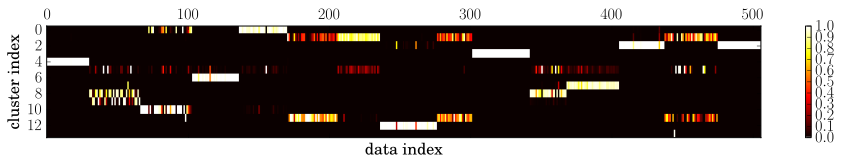

In [14]:
phi = m.get_phi()
_=plt.matshow(phi.T, cmap=plt.cm.hot, vmin=0, vmax=1, aspect='auto')
plt.xlabel('data index')
plt.ylabel('cluster index')
_=plt.colorbar()

The variational posterior for each of the components in the MOG model is a Gaussian-Wishart distribution. These are stored in the model as:

In [15]:
mun, Sns = m.get_means_and_covariances()
print('first component mean:', mun[:,0])
print('first component covariance:\n', Sns[:,:,0])


('first component mean:', array([ 0.07297507,  0.01515727, -0.0769152 ,  0.15236892,  0.02573517,
       -0.04722979, -0.20213203, -0.06989026, -0.13014355, -0.144744  ,
        0.08678935,  0.01204276, -0.04847413, -0.05576244]))
('first component covariance:\n', array([[  2.00153857e-02,  -1.47566293e-02],
       [  1.18746319e-02,  -1.12374308e-02],
       [  1.18075263e-01,   4.64202732e-02],
       [  1.10919945e-02,  -6.50372231e-03],
       [  5.56004218e-03,   1.89708065e-03],
       [  1.43872612e-01,   7.06313619e-02],
       [  2.15552087e-02,  -7.07660008e-03],
       [  6.91171830e-03,   2.76268022e-03],
       [  6.95889574e-03,   1.64397873e-03],
       [  3.43585600e-03,   3.08307929e-04],
       [  4.15117461e-03,  -5.23222326e-03],
       [  3.04550839e-02,   1.23936216e-02],
       [  6.90075677e-03,  -1.24710643e-03],
       [  1.00781302e-03,   6.13984554e-06]]))


Finally, to obtain the predictive density of the model at any point, we can use `m.predict`. To get the density under each of the components, we can use `m.predict_components'.

In [16]:
test_point = np.array([[0.1, 0.0]])
density = m.predict(test_point)
print('model density:',density)

cw_density = m.predict_components(test_point)
print('density under each component:', cw_density.round(3))


('model density:', array([ 8.06065763]))
('density under each component:', array([[  1.04420000e+01,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.30000000e-02,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.28667000e+02,   2.96000000e-01,
          0.00000000e+00,   3.02000000e-01]]))


## Adjusting the prior parameters
The MOG model has priors over the component means and covariances (Gaussian-Wishart) and a Dirichlet (or Dirichlet-process) prior over the mixing proportions. We'll use the 2D dataset to illustrate how to change these prior parameters and the effect of them. 

First, let's place a strong prior over the cluster covariances that forces them to be small, and a large concentration parameter, which makes the Dirichlet process prefer a large number of clusters. 



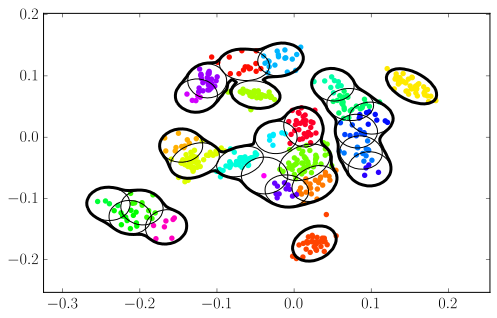

('bound on the marginal likelihood:', 2969.4367459328796)


In [18]:
m = GPclust.MOG(X, num_clusters=10, prior_S=np.eye(2)*5e-3, prior_v=30., prior_Z='DP', alpha=100)
m.optimize(verbose=False)
m.systematic_splits(verbose=False)
MOGplot(m,X)
print('bound on the marginal likelihood:', m.log_likelihood())

We see that the model finds a very large number of small clusters! Now let's see what happens if we relax the concentration parameter, and reduce the strength of the Wishart prior:

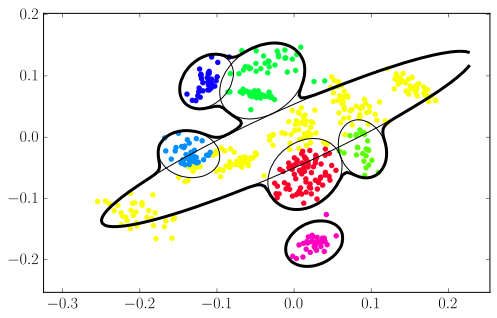

('bound on the marginal likelihood:', 1405.3979467929541)


In [19]:
m = GPclust.MOG(X, num_clusters=10, prior_S=np.eye(2)*5e-3, prior_v=10., prior_Z='DP', alpha=0.1)
m.optimize(verbose=False)
m.systematic_splits(verbose=False)
MOGplot(m,X)
print('bound on the marginal likelihood:', m.log_likelihood())

The MOG also takes a prior mean parameter (which defalts to the mean of the data) and a prior concentration parameter as part of the Wishart distribution. We leave experimenting with these to the reader. 